Runmila AI Institute & minoHealth AI Labs Tuberculosis Classification via X-Rays Challenge
This competition is hosted on Zindi and can be accessed here https://zindi.africa/competitions/runmila-ai-institute-minohealth-ai-labs-tuberculosis-classification-via-x-rays-challenge. The objective of the challenge is to build a model that can classify Tuberculosis and Normal X-Ray results.

1. Importing libraries¶

In [1]:
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
#seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

### 2. Load data

In [3]:
#mounting google drive 
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Read the .csv files
train_data = pd.read_csv('/content/drive/My Drive/TecX/Train.csv')
test_data = pd.read_csv('/content/drive/My Drive/TecX/Test.csv')
train_path = '/content/drive/My Drive/TecX/train/Train sample images/'
test_path = '/content/drive/My Drive/TecX/test/test'

train_data.head()

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0
2,train/PMRSQLXN.png,PMRSQLXN,0
3,train/JXISWDUU.png,JXISWDUU,1
4,train/JVWMAACC.png,JVWMAACC,1


In [10]:
 #creating train and test dataframe
#we will create dataframes and use keras Image data preprocessing function: flow_from_dataframe

# train
train_names = train_data.ID.values
train_labels = np.asarray(train_data['LABEL'].values)
train_dict = {'filepath': train_path + train_names + '.png', 'LABEL': train_labels}
train = pd.DataFrame(data=train_dict)
train['ID'] = train_data['ID']
train['LABEL'] = train.LABEL.apply(lambda x: 'Positive' if x == 1 else 'Negative')

# test
test_names = test_data.ID.values
test_dict = {'filepath': test_path + test_names + '.png'}
test = pd.DataFrame(data=test_dict)
test['ID'] = test_data['ID']

In [11]:
train.head()

,filepath,LABEL,ID
0,/content/drive/My Drive/TecX/train/Train sampl...,Positive,VTYNBFTO
1,/content/drive/My Drive/TecX/train/Train sampl...,Negative,GVVXXDOZ
2,/content/drive/My Drive/TecX/train/Train sampl...,Negative,PMRSQLXN
3,/content/drive/My Drive/TecX/train/Train sampl...,Positive,JXISWDUU
4,/content/drive/My Drive/TecX/train/Train sampl...,Positive,JVWMAACC


In [12]:
train['LABEL'].unique()

array(['Positive', 'Negative'], dtype=object)

In [13]:
test.head()

,filepath,ID
0,/content/drive/My Drive/TecX/test/testGTWSHFYQ...,GTWSHFYQ
1,/content/drive/My Drive/TecX/test/testQTFSSMGD...,QTFSSMGD
2,/content/drive/My Drive/TecX/test/testTBLBHSYT...,TBLBHSYT
3,/content/drive/My Drive/TecX/test/testZKETEOFG...,ZKETEOFG
4,/content/drive/My Drive/TecX/test/testGKTPBGZP...,GKTPBGZP


In [14]:
train.shape, test.shape

((718, 3), (82, 2))

### 3. EDA and Preprocessing

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


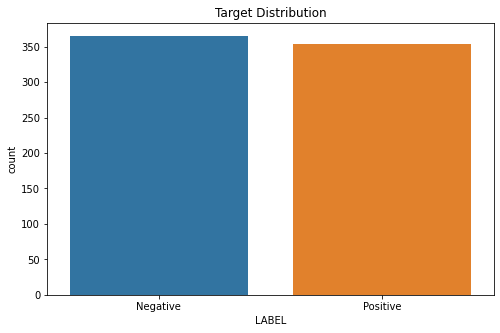

In [15]:
#visualizing target distribution 
f, ax = plt.subplots(1,1, figsize=(8,5))
sns.countplot(train['LABEL'],order = train['LABEL'].value_counts().index)
plt.title("Target Distribution")
plt.show()

In [16]:
#we can see that our dataset is balanced with almost equal number of samples in each class
train.LABEL.value_counts()/len(train)

Negative    0.508357
Positive    0.491643
Name: LABEL, dtype: float64

In [17]:
train[train['ID'] == "SWKUJZDG"]

,filepath,LABEL,ID
466,/content/drive/My Drive/TecX/train/Train sampl...,Negative,SWKUJZDG


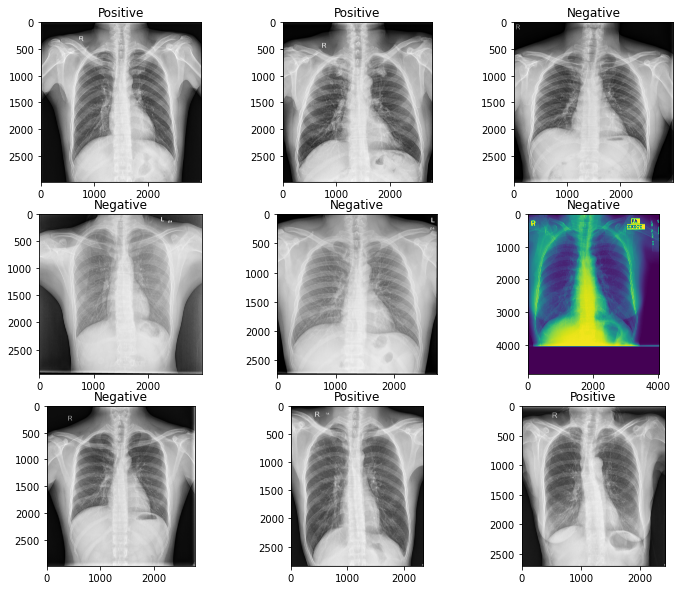

In [18]:
# visualizing random images
import matplotlib.image as mpimg

nrows = 3
rands = np.random.randint(train.shape[0], size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    
    img = mpimg.imread(train.loc[rands[i], 'filepath'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'LABEL'])
plt.show()

In [19]:
#lets split our training data into train and validation set
#We have 718 training samples and i will use 80% train and 20% validation  
df_train = train[:575:]
df_val = train[575:]
print(df_train.LABEL.value_counts())
print(df_val.LABEL.value_counts())

Negative    295
Positive    280
Name: LABEL, dtype: int64
Positive    73
Negative    70
Name: LABEL, dtype: int64


In [21]:
#data generators
batch_size = 32  
image_size = (224, 224)
learning_rate = 0.0001

train_steps = np.ceil(len(df_train) / batch_size)
val_steps = np.ceil(len(df_val) / batch_size )

classes = train.LABEL.unique().tolist()

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip=True,
                             vertical_flip=True,shear_range=10,zoom_range=0.2,width_shift_range=0.1,
                             height_shift_range=0.1,channel_shift_range=10.)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_datagen.flow_from_dataframe(df_train,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=True, seed=SEED)

val_ds = val_datagen.flow_from_dataframe(df_val,x_col='filepath', y_col='LABEL',
                                        target_size=image_size,classes=classes,
                                        batch_size=batch_size,
                                        class_mode='categorical', shuffle=False, seed=SEED)

test_ds = val_datagen.flow_from_dataframe(test, x_col='filepath',target_size=image_size, class_mode=None,
                                          shuffle=False,batch_size=batch_size)#set shuffle=False for test dataset not be shuffled

Found 575 validated image filenames belonging to 2 classes.
Found 143 validated image filenames belonging to 2 classes.
Found 0 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 82 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


### 4. Model building

In [22]:
#we will use transfer learning from VGG16 model

def BuildModel (pretrained=VGG16):

    base_model = pretrained(include_top=False, weights='imagenet', input_shape=(224, 224,3)) #include_top=False to remove the last layer 

    for layer in base_model.layers:
        layer.trainable = False   #freeze trainable layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(3072, activation='relu', )(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x) 
    
    model = Model(base_model.input, output)
    
    return model

In [23]:
model = BuildModel()

58892288/58889256 [==============================] - 0s 0us/step


In [24]:
#compile model
optimizer = keras.optimizers.Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [25]:
#callbacks
import os

earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
chkpt_path = os.path.join("Runmila_AI_Institute_Challenge/models/", f"tb_model.h5", )
checkpoint = ModelCheckpoint(chkpt_path, monitor='val_loss',mode='auto', verbose=1, save_best_only=True,)


In [ ]:
# fit model
history = model.fit(train_ds, epochs=15,steps_per_epoch=train_steps, callbacks=[earlystop, checkpoint],
                    verbose=1, shuffle=False,validation_data=(val_ds), validation_steps= val_steps)

Epoch 1/15
18/18 [==============================] - 585s 33s/step - loss: 0.8420 - auc: 0.5789 - val_loss: 0.5879 - val_auc: 0.7906

Epoch 00001: val_loss improved from inf to 0.58788, saving model to Runmila_AI_Institute_Challenge/models/tb_model.h5
Epoch 2/15
18/18 [==============================] - 436s 24s/step - loss: 0.5756 - auc: 0.8237 - val_loss: 0.5373 - val_auc: 0.8150

Epoch 00002: val_loss improved from 0.58788 to 0.53731, saving model to Runmila_AI_Institute_Challenge/models/tb_model.h5
Epoch 3/15
18/18 [==============================] - 438s 24s/step - loss: 0.5800 - auc: 0.8191 - val_loss: 0.5678 - val_auc: 0.7904

Epoch 00003: val_loss did not improve from 0.53731
Epoch 4/15
18/18 [==============================] - 439s 24s/step - loss: 0.5131 - auc: 0.8626 - val_loss: 0.5731 - val_auc: 0.7877

Epoch 00004: val_loss did not improve from 0.53731
Epoch 5/15
18/18 [==============================] - 440s 24s/step - loss: 0.5259 - auc: 0.8598 - val_loss: 0.4895 - val_auc: 0

In [ ]:
!pip install streamlit

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('my_model.hdf5')

In [ ]:
import streamlit as st
st.write("""
         # Rock-Paper-Scissor Hand Sign Prediction
         """
         )
st.write("This is a simple image classification web app to predict patient TB X-Ray images.")
file = st.file_uploader("Please upload an image file", type=["jpg", "png"])

In [ ]:
import cv2
from PIL import Image, ImageOps
import numpy as np
def import_and_predict(image_data, model):
    
        size = (300,300)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img_resize[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    prediction = import_and_predict(image, model)
    
    if np.argmax(prediction) == 0:
        st.write("Patient diagnosis is Negative!!")
    else:
        st.write("Patient diagnosis is positive!")
    
    st.text("Probability (0: Negative, 1: Positive)")
    st.write(prediction)